# Import Statements

In [1]:
%pylab --no-import-all inline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import pandas as pd
import re
import string
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

import spacy
nlp = spacy.load('en', parse=True, tag=True, entity=True)

from gensim import corpora, models, similarities

Populating the interactive namespace from numpy and matplotlib


C:\Users\dweep\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load Data

Load the attached dataset in “Tweets.csv”.

In [2]:
df=pd.read_csv('tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


select columns important for sentiment analysis and remove any rows that has no features/label

In [3]:
df = df.iloc[:][["airline_sentiment", "airline", "retweet_count", "text"]]
df = df.dropna(axis=0, how='all')
df = df.reset_index(drop=True)
print('Number of observations are: '+str(len(df)))
df.head()

Number of observations are: 14640


,airline_sentiment,airline,retweet_count,text
0,neutral,Virgin America,0,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,0,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,0,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,0,@VirginAmerica and it's a really big bad thing...


## Sentiment class counts

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


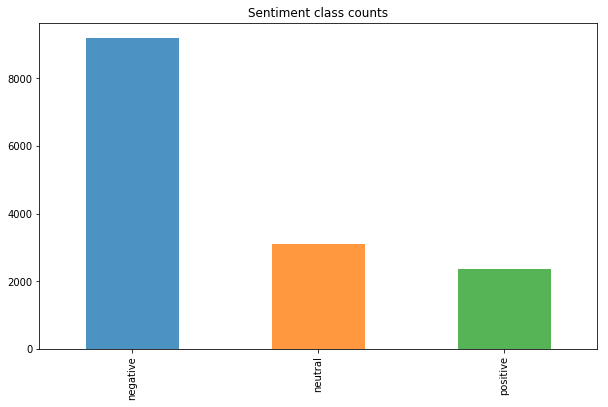

In [4]:
#count number of tweets for each sentiment class
print(df.airline_sentiment.value_counts())
df.airline_sentiment.value_counts().plot(kind='bar', figsize=(10, 6), alpha=0.8, title="Sentiment class counts")

## Airline Sentiment Distribution

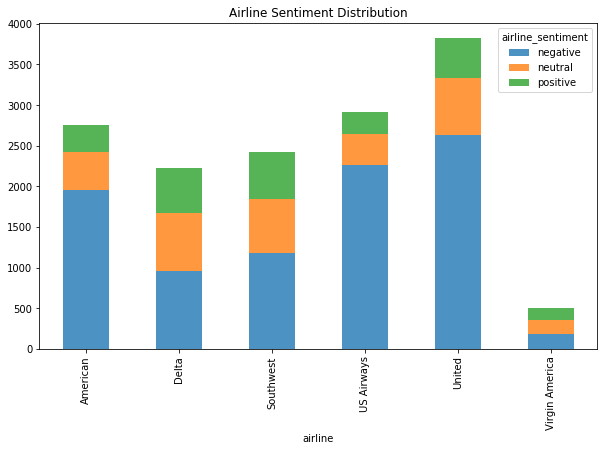

In [5]:
#tweet distribution for each airline
pd.crosstab(index = df["airline"],columns = df["airline_sentiment"]).plot(kind='bar', figsize=(10, 6),
            alpha=0.8, stacked=True, title="Airline Sentiment Distribution")

# feature extraction

## 1) extract features from tweet text

In [6]:
#convert dataframe to numpy array
dataset = df.values

#Create list of all tweets
tweets = dataset[:,3]
print(tweets[0])

@VirginAmerica What @dhepburn said.


Remove mentions (cell taken from hands on coding session notebook DSSS_Lab5-Deb.ipynb)

In [7]:
def strip_mentions(text):
    entity_prefixes = ['@']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [8]:
for i in range(len(tweets)):
    tweets[i]=strip_mentions(tweets[i])

Remove hashtags (cell taken from hands on coding session notebook DSSS_Lab5-Deb.ipynb)

In [9]:
def strip_hashtags(text):
    entity_prefixes = ['#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [10]:
for i in range(len(tweets)):
    tweets[i]=strip_hashtags(tweets[i])

Remove retweet (RT) designation (cell taken from hands on coding session notebook DSSS_Lab5-Deb.ipynb)

In [11]:
for i in range(len(tweets)):
    tweets[i] = tweets[i].replace('RT', '')

Remove spcial or accented characters and maybe numbers (cell taken from hands on coding session notebook DSSS_Lab5-Deb.ipynb)

In [12]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [13]:
for i in range(len(tweets)):
    tweets[i]=remove_special_characters(tweets[i], remove_digits=True)

Remove stopwords (cell taken from hands on coding session notebook DSSS_Lab5-Deb.ipynb)

In [14]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [15]:
for i in range(len(tweets)):
    tweets[i]=remove_stopwords(tweets[i])

Stemming (cell taken from hands on coding session notebook DSSS_Lab5-Deb.ipynb)

In [16]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [17]:
for i in range(len(tweets)):
    tweets[i]=simple_stemmer(tweets[i])

Lemming (cell taken from hands on coding session notebook DSSS_Lab5-Deb.ipynb)

In [18]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [19]:
import time
t1 = time.time()

for i in range(len(tweets)):
    tweets[i]=lemmatize_text(tweets[i])

t2 = time.time()
print(t2-t1," s")

155.38978338241577  s


Initiate TfidfVectorizer

In [20]:
#sklearn’s TfidfVectorizer class to represent the text by the TF-IDF weighting of the features.
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words='english', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)
print(vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


## 2) extract number of retweets

In [21]:
#feature 2: number of retweets
retweets = dataset[:,2]

## 3) extract airline as one-hot-encoded feature

In [22]:
#feature 3: one-hot encoding of airline
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(dataset[:,1])
airlines = lb.transform(dataset[:,1])
print(airlines.shape)

(14640, 6)


get labels from the dataset

In [23]:
#label
airline_sentiment = dataset[:,0]

# Decision Tree Classifier

Instantiate a DecisionTreeClassifier

In [24]:
from sklearn import tree, neighbors
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=300)

# K fold cross validation

Split the dataset in training and testing sets using KFold Cross Validation (K=10)

In [25]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack,coo_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# K-fold construction
folds = 10
fold_metrics = {}
kf = KFold(n_splits=folds, shuffle=True) 


# K-fold cross validation and performance evaluation
foldid = 0
totacc = 0.
ytlog = []
yplog = []
acc_log = []
for train_index, test_index in kf.split(tweets):
    foldid += 1
    print("Starting Fold %d" % foldid)
    print("\tTRAIN:", len(train_index), "TEST:", len(test_index))
    
    feature1_train = vectorizer.fit_transform(tweets[train_index])
    feature1_test = vectorizer.transform(tweets[test_index])
    
    #use sparse matrix to speed up training
    feature2_train, feature2_test = coo_matrix(airlines[train_index],dtype=np.float64), coo_matrix(airlines[test_index],dtype=np.float64)
    feature3_train, feature3_test = coo_matrix(retweets[train_index].reshape(-1,1),dtype=np.float64), coo_matrix(retweets[test_index].reshape(-1,1),dtype=np.float64)
    
    X_train = hstack((feature1_train,feature2_train,feature3_train))
    X_test = hstack((feature1_test,feature2_test,feature3_test))
    
    #feature normalization
    X_scaler = StandardScaler(with_mean=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    y_train, y_test = airline_sentiment[train_index], airline_sentiment[test_index]
  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_pred, y_test)
    acc_log.append(acc)
    totacc += acc
    fold_metrics[foldid] = classification_report(y_test, y_pred, target_names=["negative","neutral","positive"], output_dict=True)
    print(classification_report(y_test, y_pred, target_names=["negative","neutral","positive"]))
    
    ytlog += list(y_test)
    yplog += list(y_pred)
    print('\tAccuracy:', acc)
    print('----------------------------------------------------')

print()
print("Average Accuracy: %0.3f" % (totacc / folds,))
avg_fold_metric = classification_report(ytlog, yplog, target_names=["negative","neutral","positive"], output_dict=True)
print(classification_report(ytlog, yplog, target_names=["negative","neutral","positive"]))

Starting Fold 1
	TRAIN: 13176 TEST: 1464
              precision    recall  f1-score   support

    negative       0.78      0.85      0.82       919
     neutral       0.51      0.36      0.42       321
    positive       0.61      0.64      0.62       224

   micro avg       0.71      0.71      0.71      1464
   macro avg       0.63      0.62      0.62      1464
weighted avg       0.69      0.71      0.70      1464

	Accuracy: 0.7110655737704918
----------------------------------------------------
Starting Fold 2
	TRAIN: 13176 TEST: 1464
              precision    recall  f1-score   support

    negative       0.77      0.81      0.79       913
     neutral       0.45      0.40      0.42       310
    positive       0.60      0.56      0.58       241

   micro avg       0.68      0.68      0.68      1464
   macro avg       0.61      0.59      0.60      1464
weighted avg       0.67      0.68      0.68      1464

	Accuracy: 0.6830601092896175
-------------------------------------------

# Performance evaluatoin

## accuracy at each fold

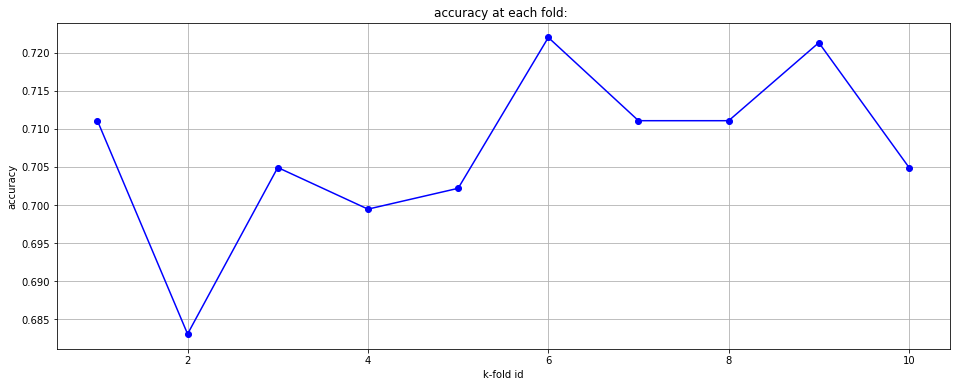

In [26]:
plt.figure(figsize=(16,6))
plt.title("accuracy at each fold: ")
plt.xlabel("k-fold id")
plt.ylabel("accuracy")
plt.grid()
plt.plot(list(range(1,foldid+1)), acc_log, 'o-', color='b', linestyle='-')

function to plot classification reports

In [27]:
import matplotlib.pyplot as plt

def plot_metrics(df, target_names, metric_list, line_style_dic, color_style_dic,avg_flag=False):
    for column in list(df.columns):
        class_metrics = df.iloc[:][column]
        if column not in target_names:
            continue
        plt.figure(figsize=(16,6))
        if avg_flag == True:
            plt.title("average(of 3 classes) learning curves: "+column)
        else:
            plt.title("learning curves for class: "+column)         
        plt.xlabel("k-fold id")
        plt.ylabel("Score")
        plt.grid()
        df2 = pd.DataFrame.from_dict(dict(class_metrics),orient='index')
        for column2 in list(df2.columns):
            if column2 in metric_list:    
                plt.plot(list(range(1,foldid+1)), df2[:][column2], 'o-', color=color_style_dic[column2], label=column2,linestyle=line_style_dic[column2])
                plt.legend(loc="upper right")

## precision, recall, f1-score for each class at each fold 

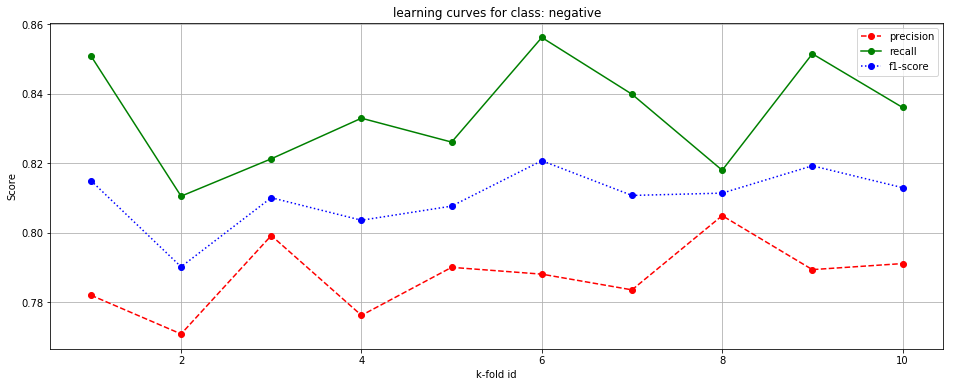

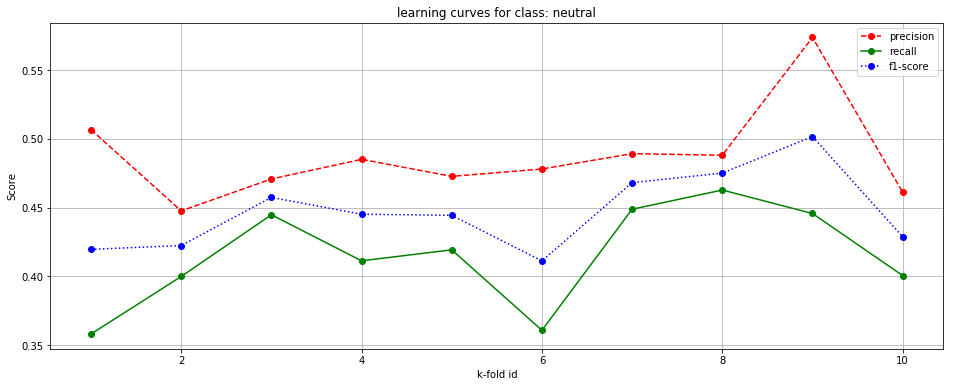

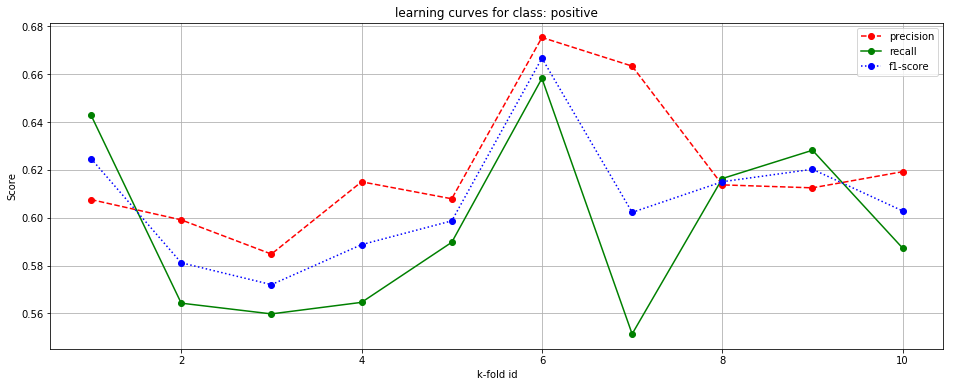

In [28]:
target_names = ["negative","neutral","positive"]
metric_list = ["precision","recall","f1-score"]
#line_style_dic = {"negative":"--","positive":"-","neutral":":"}
line_style_dic = {"precision":"--","recall":"-","f1-score":":"}
color_style_dic = {"precision":"r","recall":"g","f1-score":"b"}
df = pd.DataFrame.from_dict(fold_metrics, orient='index')

plot_metrics(df, target_names, metric_list, line_style_dic, color_style_dic)

## Average (of 3 class) precision, recall, f1-score at each fold

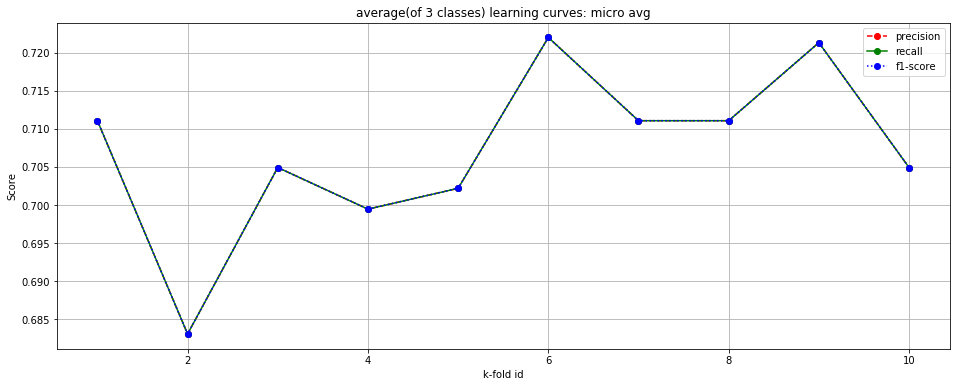

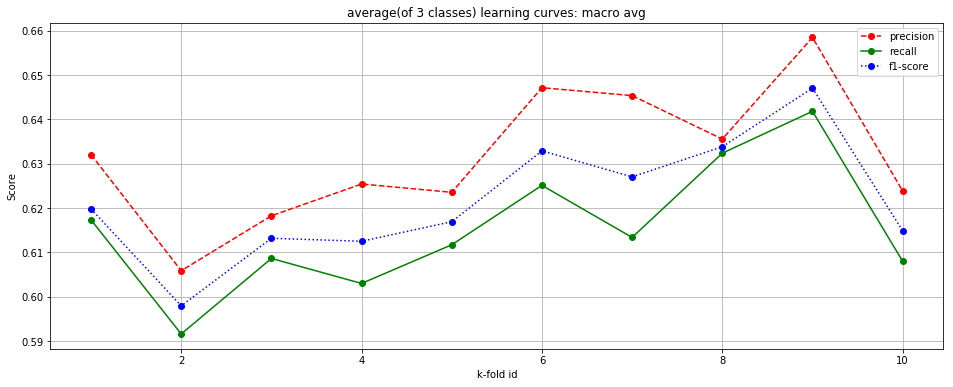

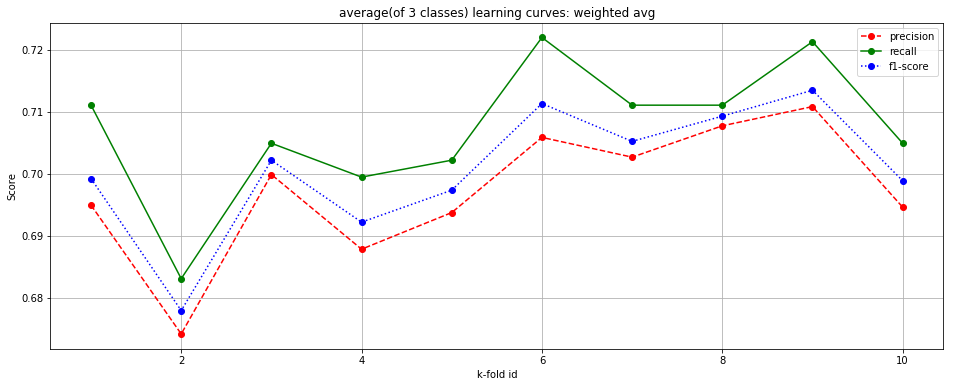

In [29]:
target_names = ["micro avg","macro avg","weighted avg"]
metric_list = ["precision","recall","f1-score"]
line_style_dic = {"precision":"--","recall":"-","f1-score":":"}
color_style_dic = {"precision":"r","recall":"g","f1-score":"b"}
df = pd.DataFrame.from_dict(fold_metrics, orient='index')

plot_metrics(df, target_names, metric_list, line_style_dic, color_style_dic, avg_flag=True)

# Compute average of 10 folds

## Average accuracy, precision, recall, f1-score for each class

In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
target_names = ["negative","neutral","positive"]

df = pd.DataFrame.from_dict(avg_fold_metric, orient='columns')
print("")
for column in target_names:
    class_dict = dict(df[:][column])
    print("class: "+ column)
    for item in class_dict:
        print("10-fold average ",item,":",class_dict[item])
    print("======")
    print()


class: negative
10-fold average  f1-score : 0.8101788170563963
10-fold average  precision : 0.7874331550802139
10-fold average  recall : 0.8342776203966006
10-fold average  support : 9178.0

class: neutral
10-fold average  f1-score : 0.4482758620689655
10-fold average  precision : 0.4869466515323496
10-fold average  recall : 0.41529525653436594
10-fold average  support : 3099.0

class: positive
10-fold average  f1-score : 0.6074201898188093
10-fold average  precision : 0.6194456665200176
10-fold average  recall : 0.5958527295810411
10-fold average  support : 2363.0



# Average performance: accuracy, precision, recall, f1-score

overall 10-fold average:
precision: 0.63
recall: 0.62
f1-score: 0.62

accuracy:70.71%


<BarContainer object of 4 artists>

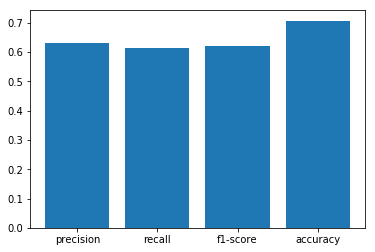

In [31]:
print("overall 10-fold average:")
precision, recall, fbeta_score, _ = precision_recall_fscore_support(ytlog, yplog, average='macro')
acc = accuracy_score(ytlog, yplog)
print("precision:",round(precision,2))
print("recall:",round(recall,2))
print("f1-score:",round(fbeta_score,2))
print("\naccuracy:{}%".format(round(acc*100,2)))

plt.figure()
plt.bar(["precision","recall","f1-score","accuracy"],[precision,recall,fbeta_score,acc])